#TODO

In [1]:
import sys
sys.path.append('../')

import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn

import torch_geometric as pyg
from torch_geometric.utils.convert import from_networkx

from src.utils import *
from dataset import *
from src.train import train, test
from src.dataloaders import make_data_loaders_from_dataset
from src.model import KnnEstimator

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [33]:
class StandardScaler:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

In [2]:
G = nx.readwrite.read_gpickle('data/network64.gpickle')

In [5]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_graph = from_networkx(G, ['population', 'jobs'])
pyg_graph.to(device)

Data(x=[60789, 2], edge_index=[2, 151294], lon=[60789], lat=[60789], id=[60789], dist=[151294])

In [34]:
pyg_graph.x = StandardScaler().fit_transform(pyg_graph.x)
pyg_graph.x

tensor([[ 2.7330,  0.0446],
        [ 2.7330,  0.0446],
        [ 0.6586, -0.1095],
        ...,
        [ 0.8096, -0.1095],
        [ 0.8096, -0.1095],
        [ 0.8096, -0.1095]], device='cuda:0')

$$T(a) = \sum_{b \neq a,\space b\subset Train } T(b)w(a, b)\frac{v(a)}{v(b)}, \textrm{where summation is calculated for the {\bf k} nearest neighbors.}$$

$$ w(a,b)= \frac{e^{u(a,b)}}{\sum_{b \neq a} e^{u(a, b)}} ;$$

$u(a, b) = exp(-\lambda_1 d(a, b));$

$v(a) = MLP(x_a)$

$x_a$ is an embedding for a node **a**;

So for this model $\lambda_1$, $MLP$ parameters are optimized.

In [55]:
def weight_fn(dists, lamb):
    return torch.exp(-lamb * dists)


class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.out_activation = nn.ReLU()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.Linear(8, 1),
        )

    def forward(self, X, neighbors=False):
        if neighbors:
            out_shape = X.shape[:2]
            X = X.reshape(-1, X.shape[-1])

        out = self.layers(X)

        if neighbors:
            out = out.reshape(*out_shape)

        out = self.out_activation(out) + 1

        return out


class Estimator(KnnEstimator):
    def __init__(self, pyg_graph: pyg.data.Data, obs_nodes, obs_targets) -> None:
        super().__init__(pyg_graph, obs_nodes, obs_targets)

        self.scale_mlp = MLP(self.g.x.shape[-1])
        self.lambda_1 = nn.Parameter(torch.rand(1))
        self.a = nn.Parameter(torch.rand(1))
        self.b = nn.Parameter(torch.rand(1))

    def forward(self, X):
        # getting nearest observed nodes
        X_indices = torch.as_tensor(self.node_to_idx(X))
        dists, indices = self.get_kneighbors(X_indices)
        dists = dists.to(device)

        targets = self.obs_targets[indices].to(device)

        # finding corresponding node embedding of neighbors
        neighbors_indices = torch.as_tensor(self.node_to_idx(self.obs_nodes[indices]), device=device)
        neighbors_embeds = self.g.x[neighbors_indices]
        
        # computing similarities between node ans its neighbors
        X_embeds = self.g.x[X_indices]
        neighbors_scales = self.scale_mlp(neighbors_embeds, neighbors=True)
        X_scales = self.scale_mlp(X_embeds)

        # dists = dists * self.a + self.b
        # print(dists[0][:5])

        dist_weights = weight_fn(dists, self.lambda_1)
   
        # sum normalizization
        dist_weights = nn.functional.normalize(dist_weights, p=1)

        att_weights = dist_weights

        # print(torch.div(X_scales, neighbors_scales)[0][:5])

        targets = targets * torch.div(X_scales, neighbors_scales)

        # interpolation 
        result = torch.sum(att_weights.mul(targets), dim=-1)

        return result

In [56]:
results = dict()

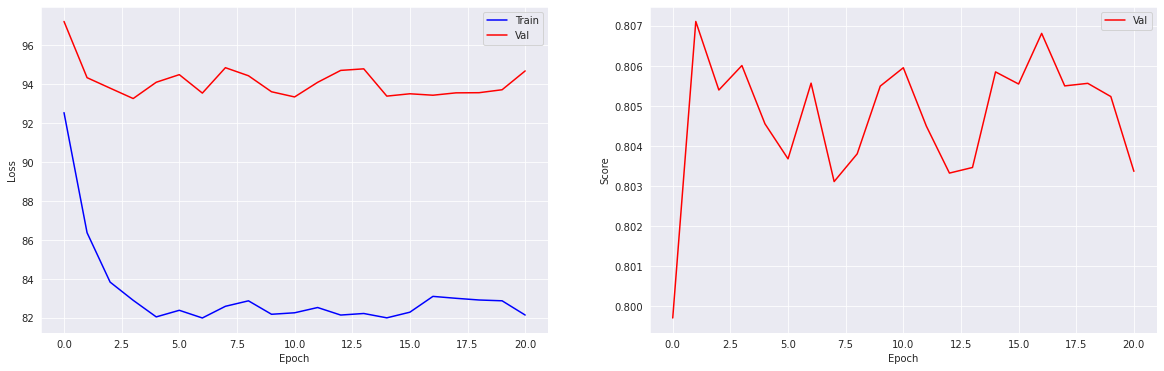

day_24, Test loss: 101.3905, test score: 0.7193


In [59]:
loss_fn = nn.HuberLoss(delta=20).to(device)
model = None

for path in tqdm(glob.glob('datasets/*')[:1]):
    day = path.split('/')[1].split('.')[0]

    try:
        ds = torch.load(path)
    except:
        continue

    train_loader, val_loader, test_loader = make_data_loaders_from_dataset(ds, batch_size=128)
    train_batches = [batch for batch in train_loader]
    train_nodes = [n for batch in train_batches for n in batch[0]]
    train_targets = torch.cat([batch[1] for batch in train_batches])


    if model is None:
        model = Estimator(pyg_graph, train_nodes, train_targets).to(device)
    else:
        model.set_observations(train_nodes, train_targets)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    best_model = train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=20, plotting=True)
    test_loss, test_score = test(best_model, test_loader, loss_fn, device)

    # for name, param in best_model.named_parameters():
        # print(name, param)

    results[f'{day}'] = test_score 
    print(f'{day}, Test loss: {test_loss:.4f}, test score: {test_score:.4f}')

In [23]:
import json

with open('results/gnn1.json', mode='w') as f:
    json.dump(results, f, indent=4)